# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [2]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.1975, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5','s2','s6','s7','s4','s3']
plotting_order_1percent = ['s11','s08','s12','s13','s10','s09']
colors = {'s2':'tab:orange', 's3':'tab:purple','s4':'tab:brown',
                   's5':'tab:blue', 's6':'tab:red', 's7':'tab:green',
                   's08':'tab:orange', 's09':'tab:purple','s10':'tab:brown',
                   's11':'tab:blue', 's12':'tab:red', 's13':'tab:green'}
lines = {'s2':':', 's3':(0,(5,3)),'s4':'-.','s5':(0,(5,1)), 's6':(0,(5,5)), 's7':(0, (3,1,1,1)),
                's08':':', 's09':(0,(5,3)),'s10':'-.','s11':(0,(5,1)), 's12':(0,(5,5)), 's13':(0, (3,1,1,1))}
labels = {'s2':'Scenario 2', 's3':'Scenario 3', 's4':'Scenario 4', 's5':'Scenario 5',
         's6':'Scenario 6', 's7':'Scenario 7', 's08':'Scenario 8', 's09':'Scenario 9',
         's10':'Scenario 10', 's11':'Scenario 11', 's12':'Scenario 12', 's13':'Scenario 13'}
legend_order = [1, 5, 4, 0, 2, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [42]:
s1_outfile = "../outputs/united_states_2020.sqlite"

In [43]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

In [44]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [45]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1091])
print(s1_reactors[['lwr_total','Year']][30:35])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
Prototype  lwr_total     Year
30               0.0  1967.50
31               0.0  1967.58
32               2.0  1967.67
33               2.0  1967.75
34               2.0  1967.83


In [46]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

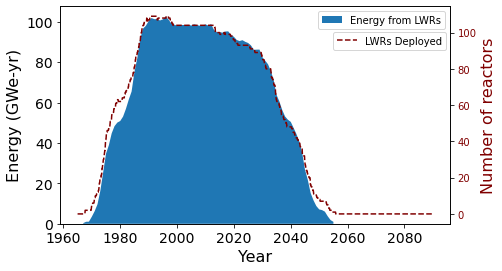

In [47]:
#combine energy and reactors for scenario 1 into a single plot
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
ax1.stackplot(s1_energy['Year'], s1_energy['Energy'], labels=['Energy from LWRs'])
ax1.legend()
ax1.set_ylabel('Energy (GWe-yr)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(s1_reactors['Year'], s1_reactors['lwr_total'], 'maroon', 
         linestyle='--', label='LWRs Deployed')
ax2.legend(loc=(0.7, 0.8))
ax2.set_ylabel('Number of reactors', color='maroon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='maroon')

ax1.set_xlabel('Year', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figures/s1_energy_reactors.pdf', bbox_inches='tight')

In [48]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

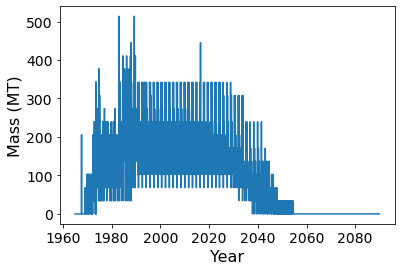

In [49]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf', bbox_inches='tight')

In [50]:
print('Max uranium:',s1_uox['Quantity'].max()/1000)
print('Average across entire time:',s1_uox['Quantity'][32:1089].mean()/1000)
print('Average after 2025:',s1_uox['Quantity'][721:1089].mean()/1000)
print('Average before 2025:',s1_uox['Quantity'][32:721].mean()/1000)
print('Total after 2025:', s1_uox['Quantity'][721:].cumsum()[1499]/1000)
print('Total:', s1_uox['Quantity'].cumsum()[1499]/1000)

Max uranium: 513.7178423236442
Average across entire time: 135.74253053148882
Average after 2025: 81.11040952552757
Average before 2025: 164.92195074947685
Total after 2025: 29848.63070539421
Total: 143479.85477178285


1151208.2281102058


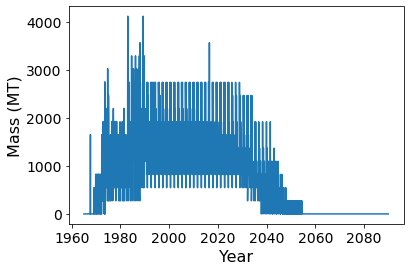

In [51]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)
print(s1_feed.cumsum()[1499]/1000)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [52]:
print('Maximum needed:',s1_feed.max()/1000)
print('Average feed:',s1_feed[32:1089].mean()/1000)
print('Average feed after 2025:', s1_feed[721:1089].mean()/1000)
print('Average feed before 2025:', s1_feed[32:721].mean()/1000)
print('Total after 2025:', s1_feed[721:].cumsum()[1499]/1000)
print('Total:', s1_feed.cumsum()[1499]/1000)

Maximum needed: 4121.806562675031
Average feed: 1089.1279357712408
Average feed after 2025: 650.7880216333915
Average feed before 2025: 1323.2485285183072
Total after 2025: 239489.9919610876
Total: 1151208.2281102058


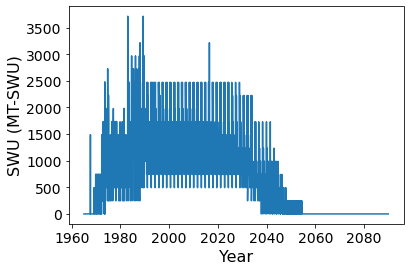

In [53]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (MT-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [54]:
print('Maximum needed:',s1_swu.max()/1000)
print('Average SWU:',s1_swu[32:1089].mean()/1000)
print('Average SWU after 2025:', s1_swu[721:1089].mean()/1000)
print('Average SWU before 2025:', s1_swu[32:721].mean()/1000)

Maximum needed: 3714.1664210974054
Average SWU: 981.4149077135144
Average SWU after 2025: 586.4261169098742
Average SWU before 2025: 1192.3813446013803


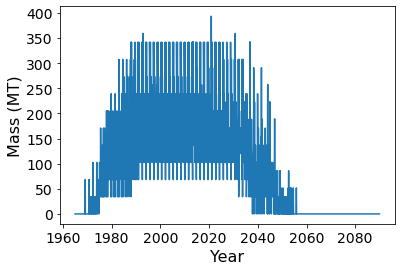

In [55]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf', bbox_inches='tight')

In [56]:
print('Maximum needed:',s1_waste['Quantity'].max())
print('Average waste:',s1_waste['Quantity'][32:1089].mean())
print('Average waste after 2025:', s1_waste['Quantity'][721:1089].mean())
print('Average waste before 2025:', s1_waste['Quantity'][32:721].mean())
print('Cumulative:', s1_waste['Quantity'].cumsum()[1499]/1000)

Maximum needed: 393622.40663899935
Average waste: 130113.73298735515
Average waste after 2025: 93898.30642251472
Average waste before 2025: 149456.66038338022
Cumulative: 137581.92946057965


## No growth scenarios

In [7]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

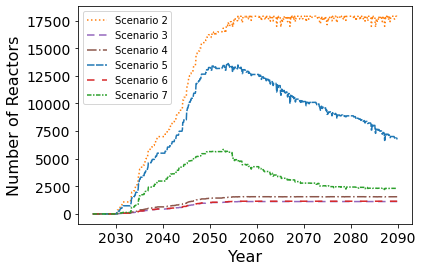

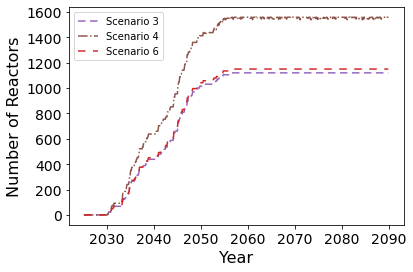

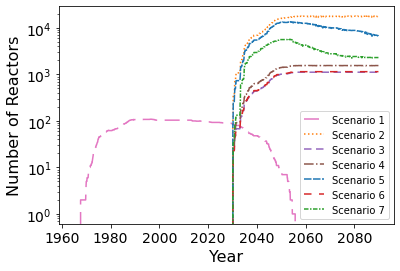

In [103]:
reactors_nogrowth = {'s2_reactors':'',
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
plt.figure(0)
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s3_reactors','s4_reactors','s6_reactors']:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
            label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors_3-7.pdf', bbox_inches='tight')

plt.figure(2)
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'], label='Scenario 1', color='tab:pink', 
        linestyle=(0,(10,5)))
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'], reactors_nogrowth[key]['advrx_total'], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.yscale('log')
plt.savefig('figures/reactors_1-7.pdf', bbox_inches='tight')

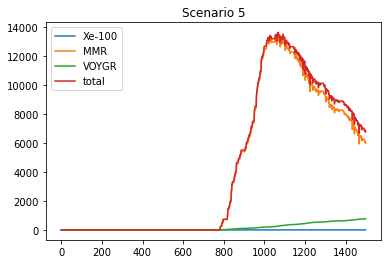

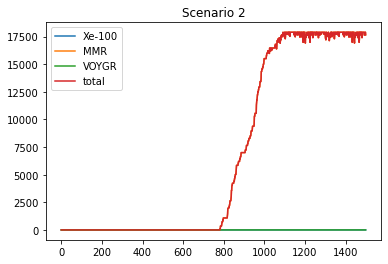

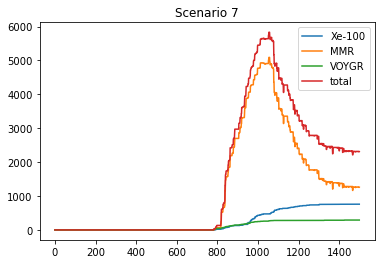

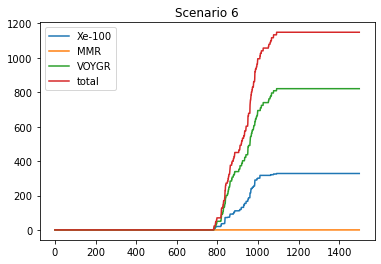

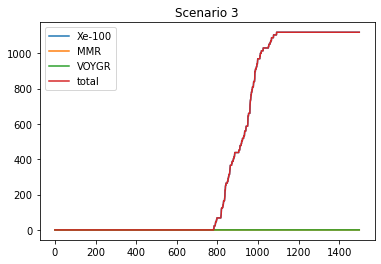

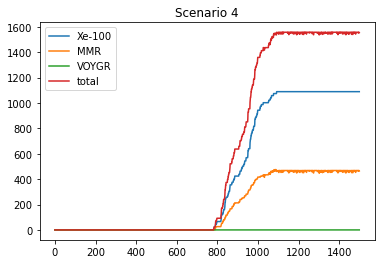

In [59]:
for scenario in plotting_order_nogrowth:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_nogrowth[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_nogrowth[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [60]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 17892.0
Max MMR added in one step in S2: 756.0
Total number of MMR deployed in S2: 51774.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2: 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2: 0.0
Max Adv Rx in S2: 17892.0
Max Adv Rx added in one step in S2: 756.0
Total number of reactors deployed in S2: 51774.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3: 0.0
Max Xe-100 in S3: 1119.0
Max Xe-100 added in one step in S3: 47.0
Total number of Xe-100 deployed in S3: 1119.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3: 0.0
Max Adv Rx in S3: 1119.0
Max Adv Rx added in one step in S3: 47.0
Total number of reactors deployed in S3: 1119.0
Max MMR in S4: 475.0
Max MMR added in one step in S4: 15.0
Total number of MMR deployed in S4: 1358.0
Max Xe-100 in S4: 1089.0
Max Xe-100 added in

In [61]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])

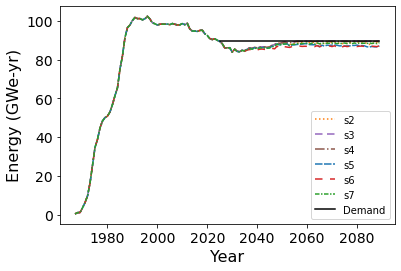

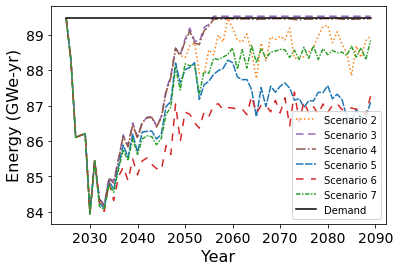

In [89]:
for key in energy_nogrowth:
    scenario = key[:2]
    
    plt.figure(0)
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
    
    plt.figure(1)
    plt.plot(energy_nogrowth[key]['Year'][58:], energy_nogrowth[key]['Energy'][58:], label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy_after_2025.pdf', bbox_inches='tight')

s2_energy : -0.0034500000000008413 5.515800000000738
s3_energy : -0.06345000000000312 5.468300000000056
s4_energy : -0.0034500000000008413 5.515800000000013
s5_energy : 4.999999998744897e-05 5.516633333333928
s6_energy : 4.999999998744897e-05 5.502300000000048
s7_energy : 4.999999998744897e-05 5.51663333333336


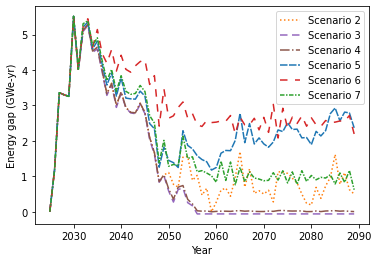

In [63]:
demand = np.repeat(89.45655,65)

for key in energy_nogrowth:
    scenario = key[:2]
    gap = demand-energy_nogrowth[key]['Energy'][58:]
    plt.plot(energy_nogrowth[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario],
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend()
plt.savefig('figures/nogrowth_energy_gap.pdf')

In [8]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2':'', 's3':'', 's4':'',
             's5':'', 's6':'', 's7':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = tm.add_year(fuel)

In [16]:
#Dividing fuel mass by prototype
uranium_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in uranium_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_nogrowth[key]['Quantity'] = uranium_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor]

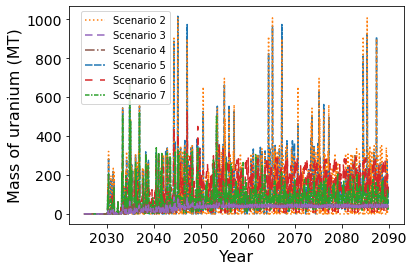

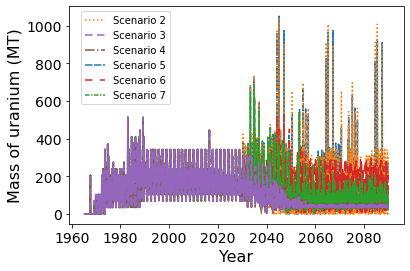

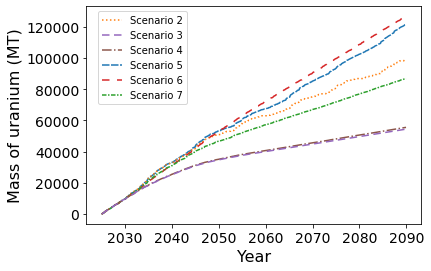

In [18]:
for key in plotting_order_nogrowth:
      
    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_nogrowth[key + '_MMR'].copy()

    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_nogrowth[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium[721:]['Quantity']/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    uranium_to_reactors_nogrowth[key + '_total'] = AR_uranium['Quantity'] 
    uranium_to_reactors_nogrowth[key + '_total'] += uranium_to_reactors_nogrowth[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax3 = plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], 
            uranium_to_reactors_nogrowth[key+'_total'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/nogrowth_uranium_cumulative.pdf', bbox_inches='tight')

In [93]:
yearly_average = pd.DataFrame(columns=['Year','Average', 'Min','Max'])
yearly_average['Year'] = np.linspace(2025, 2089, 65)

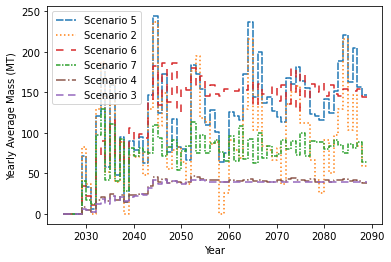

In [124]:
markers = {'s2':'s', 's3':'d','s4':'^', 's5':'*', 's6':'o','s7':'v'}
for scenario in plotting_order_nogrowth:
    averages = []
    AR_mass = uranium_to_reactors_nogrowth[scenario+'_MMR']['Quantity'] + uranium_to_reactors_nogrowth[scenario+'_VOYGR']['Quantity'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']['Quantity']
    counter = 721
    for ii in range(0,65):
        year_data = AR_mass[counter:counter+12]
        averages.append(year_data.mean())
        counter += 12
    yearly_average['Average'] = averages
    
    plt.figure(1)
    plt.step(np.linspace(2025, 2089, 65), yearly_average['Average']/1000, label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario]) 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Yearly Average Mass (MT)')
plt.savefig('figures/nogrowth_average_mass.png')

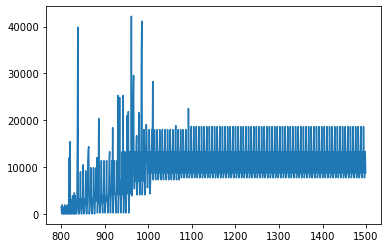

In [113]:
plt.plot(uranium_to_reactors_nogrowth['s6_Xe-100']['Quantity'][800:])

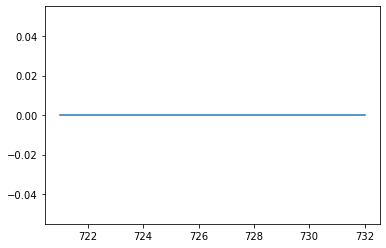

In [26]:
counter = 721

plt.plot(uranium_to_reactors_nogrowth['s2_MMR']['Quantity'][721:733])

In [179]:
#Reporting uranium masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_mass = uranium_to_reactors_nogrowth[scenario+'_MMR'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_nogrowth[scenario+'_VOYGR']
    print('Non-HALEU max in:',scenario, uranium_to_reactors_nogrowth[scenario+'_VOYGR'][721:]['Quantity'].max()/1000)
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)
    print('Cumulative mass in', scenario, 'after 2025:',AR_mass[721:]['Quantity'].cumsum()[1499]/1000)

Average HALEU mass in s2 after 2025: 88.50955741028628
Non-HALEU max in: s2 0.0
Average mass in s2 after 2025: 88.50955741028628
Maximum mass in s2 after 2025: 1006.7872404738916
Cumulative mass in s2 after 2025: 68948.94522261298
Average HALEU mass in s3 after 2025: 31.530644076385013
Non-HALEU max in: s3 0.0
Average mass in s3 after 2025: 31.530644076385013
Maximum mass in s3 after 2025: 86.78601822375043
Cumulative mass in s3 after 2025: 24562.371735503923
Average HALEU mass in s4 after 2025: 32.991198064259386
Non-HALEU max in: s4 0.0
Average mass in s4 after 2025: 32.991198064259386
Maximum mass in s4 after 2025: 101.9096222135424
Cumulative mass in s4 after 2025: 25700.14329205801
Average HALEU mass in s5 after 2025: 48.990195594440664
Non-HALEU max in: s5 235.11227046614997
Average mass in s5 after 2025: 117.79256803240516
Maximum mass in s5 after 2025: 1015.3880780129858
Cumulative mass in s5 after 2025: 91760.4104972436
Average HALEU mass in s6 after 2025: 9.233023349594035
No

In [138]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in feed_nogrowth:
    reactor = key[3:]
    if reactor != 'total':
        tails_nogrowth[key] = tm.calculate_tails(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_nogrowth[key] = tm.calculate_feed(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                           tails_nogrowth[key])
        SWU_nogrowth[key] = tm.calculate_SWU(uranium_to_reactors_nogrowth[key]['Quantity'],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

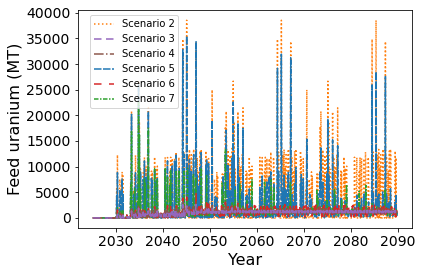

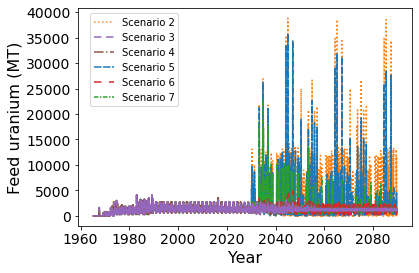

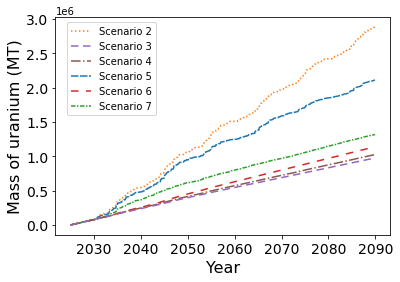

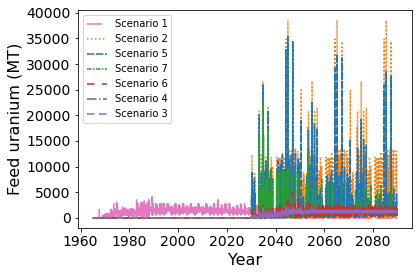

In [221]:
plt.figure(3)
plt.plot(s1_uox['Year'], s1_feed/1000, label='Scenario 1', color='tab:pink',
        linestyle=(0,(10,5)))
for key in ['s2','s5','s7','s6','s4','s3']:
    AR_feed = feed_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_nogrowth[key+'_total'] = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], feed_nogrowth[key+'_total']/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], feed_nogrowth[key+'_total'][721:].cumsum()/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_feed/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/feed_1-7.pdf', bbox_inches='tight')

order = [0, 5, 4, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_feed_cumulative.pdf', bbox_inches='tight')

In [140]:
#Reporting feed masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed_nogrowth[scenario+'_Xe-100']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)
    print('AR Cumulative mass in', scenario, 'after 2025:', AR_feed[721:].cumsum()[1499]/1000)

Average feed for HALEU in s2 after 2025: 3386.226707184143
AR Average mass in s2 after 2025: 3386.226707184143
AR Maximum mass in s2 after 2025: 38517.98542321836
AR Cumulative mass in s2 after 2025: 2637870.6048964453
Average feed for HALEU in s3 after 2025: 944.0682081579074
AR Average mass in s3 after 2025: 944.0682081579074
AR Maximum mass in s3 after 2025: 2598.4854771494747
AR Cumulative mass in s3 after 2025: 735429.1341550094
Average feed for HALEU in s4 after 2025: 1007.1074793093161
AR Average mass in s4 after 2025: 1007.1074793093161
AR Maximum mass in s4 after 2025: 3184.2180170735123
AR Cumulative mass in s4 after 2025: 784536.7263819578
Average feed for HALEU in s5 after 2025: 1874.2824341904404
AR Average mass in s5 after 2025: 2398.042177407039
AR Maximum mass in s5 after 2025: 35440.94356308363
AR Cumulative mass in s5 after 2025: 1868074.856200081
Average feed for HALEU in s6 after 2025: 276.4486443224828
AR Average mass in s6 after 2025: 1153.029793760759
AR Maximum 

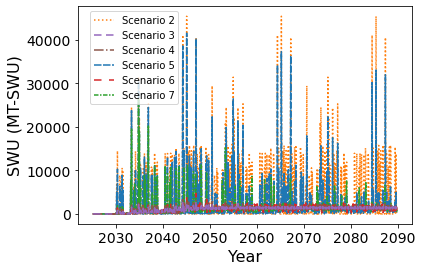

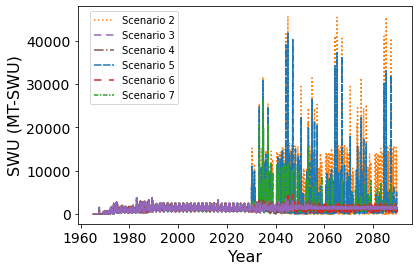

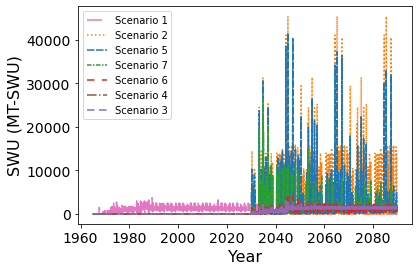

In [222]:
plt.figure(2)
plt.plot(s1_uox['Year'], s1_swu/1000, color='tab:pink', linestyle=(0,(10,5)),
        label='Scenario 1')
for key in ['s2', 's5', 's7', 's6', 's4', 's3']:
    AR_SWU = SWU_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_nogrowth[key+'_total'] = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_SWU/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/swu_1-7.pdf', bbox_inches='tight')

handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_SWU.pdf', bbox_inches='tight')

In [142]:
#Reporting SWU Requirements
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average SWU in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum SWU in ', scenario, ':', AR_SWU[721:].max()/1000)

Average HALEU SWU in s2 after 2025: 3993.3993721183265
Average SWU in  s2 : 3993.3993721183265
Maximum SWU in  s2 : 45424.51291817138
Average HALEU SWU in s3 after 2025: 1086.8979694108166
Average SWU in  s3 : 1086.8979694108166
Maximum SWU in  s3 : 2991.6149746935052
Average HALEU SWU in s4 after 2025: 1161.9627985750794
Average SWU in  s4 : 1161.9627985750794
Maximum SWU in  s4 : 3683.0921747027833
Average HALEU SWU in s5 after 2025: 2210.353571421848
Average SWU in  s5 : 2674.7000375919088
Maximum SWU in  s5 : 41548.05169107118
Average HALEU SWU in s6 after 2025: 318.2730522689331
Average SWU in  s6 : 1095.418230615763
Maximum SWU in  s6 : 4678.33853136407
Average HALEU SWU in s7 after 2025: 1244.1637404594433
Average SWU in  s7 : 1522.038324577641
Maximum SWU in  s7 : 26459.414306378312


In [180]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor != 'total':
        waste_nogrowth[key] = tm.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

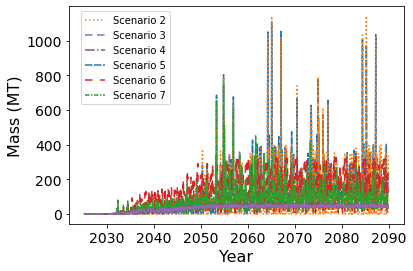

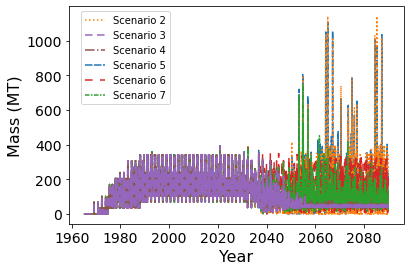

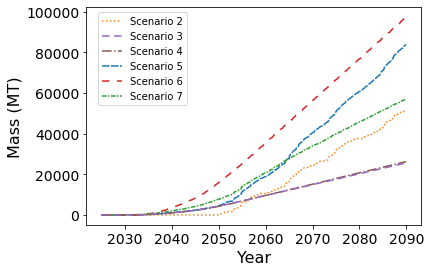

In [223]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    ax0 = plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_nogrowth[key+'_total'] = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_waste_cumulative.pdf', bbox_inches='tight')

In [184]:
#Reporting waste masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_waste = waste_nogrowth[scenario+'_MMR']['Quantity'] + waste_nogrowth[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in', scenario, ': ', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_nogrowth[scenario+'_VOYGR']['Quantity']
    print('Average AR waste in', scenario, 'after 2025:', AR_waste[721:].mean()/1000)
    print('Maximum  in', scenario, ':', AR_waste[721:].max()/1000)
    print('Cumulative  in', scenario, ':', AR_waste[721:].cumsum()[1499]/1000)

Average HALEU waste in s2 :  66.15070561489081
Average AR waste in s2 after 2025: 66.15070561489081
Maximum  in s2 : 1142.1542159999951
Cumulative  in s2 : 51531.399673999935
Average HALEU waste in s3 :  32.81184319640554
Average AR waste in s3 after 2025: 32.81184319640554
Maximum  in s3 : 55.28984999999978
Cumulative  in s3 : 25560.425849999996
Average HALEU waste in s4 :  33.64654139666229
Average AR waste in s4 after 2025: 33.64654139666229
Maximum  in s4 : 76.75488999999978
Cumulative  in s4 : 26210.655748000034
Average HALEU waste in s5 :  43.987339237483845
Average AR waste in s5 after 2025: 107.7346912272143
Maximum  in s5 : 1108.2657039999908
Cumulative  in s5 : 83925.3244659999
Average HALEU waste in s6 :  9.607490564826707
Average AR waste in s6 after 2025: 124.90677827984595
Maximum  in s6 : 331.19337000000024
Cumulative  in s6 : 97302.38028000001
Average HALEU waste in s7 :  31.77556228754809
Average AR waste in s7 after 2025: 73.04948256996144
Maximum  in s7 : 748.1789699

## 1% Growth Scenarios

In [5]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

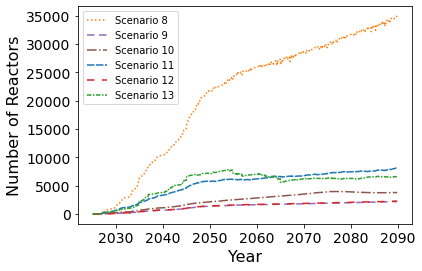

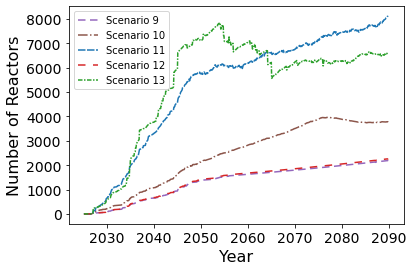

In [227]:
reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}
plt.figure(0)
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s09_reactors','s10_reactors','s11_reactors','s12_reactors','s13_reactors']:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors_9-13.pdf', bbox_inches='tight')

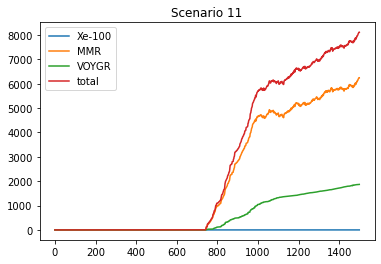

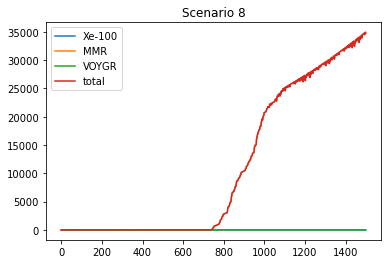

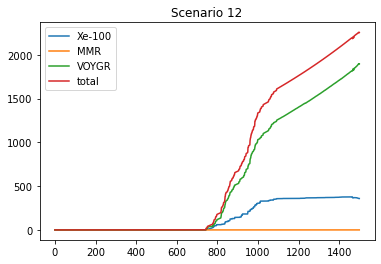

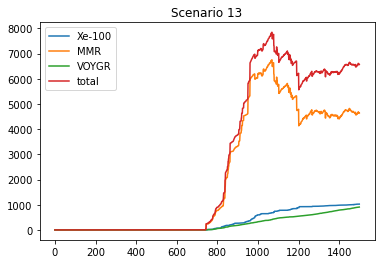

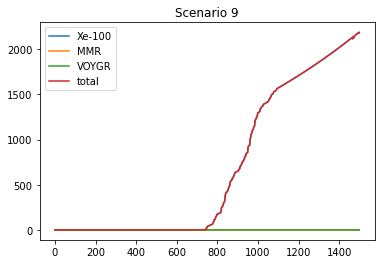

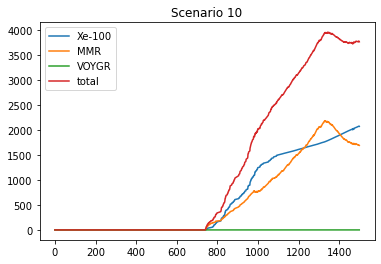

In [228]:
for scenario in plotting_order_1percent:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_1percent[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_1percent[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [229]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S08: 34933.0
Max MMR added in one step in S08: 825.0
Total number of MMR deployed in S08: 86263.0
Max Xe-100 in S08: 0.0
Max Xe-100 added in one step in S08: 0.0
Total number of Xe-100 deployed in S08: 0.0
Max VOYGR in S08: 0.0
Max VOYGR added in one step in S08: 0.0
Total number of VOYGR deployed in S08: 0.0
Max Adv Rx in S08: 34933.0
Max Adv Rx added in one step in S08: 825.0
Total number of reactors deployed in S08: 86263.0
Max MMR in S09: 0.0
Max MMR added in one step in S09: 0.0
Total number of MMR deployed in S09: 0.0
Max Xe-100 in S09: 2189.0
Max Xe-100 added in one step in S09: 49.0
Total number of Xe-100 deployed in S09: 2257.0
Max VOYGR in S09: 0.0
Max VOYGR added in one step in S09: 0.0
Total number of VOYGR deployed in S09: 0.0
Max Adv Rx in S09: 2189.0
Max Adv Rx added in one step in S09: 49.0
Total number of reactors deployed in S09: 2257.0
Max MMR in S10: 2189.0
Max MMR added in one step in S10: 15.0
Total number of MMR deployed in S10: 4471.0
Max Xe-100 in S1

In [3]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}
#for key in energy_1percent:
#    scenario = key[:3]
#    energy_1percent[key] = tm.get_annual_electricity(out_files_1percent[scenario + '_outfile'])

In [13]:
energy_1percent['s13_energy'] = tm.get_annual_electricity(out_files_1percent['s13_outfile'])

s08_energy : -3.9379147444966804 2.904525517506059
s09_energy : -4.801356553320517 2.872025517503971
s10_energy : -4.705106553320405 2.9045255175040268
s11_energy : -0.01356861507611029 2.9054421841711218
s12_energy : -0.25677643971138764 2.8964421841706383
s13_energy : -2.2505024052134672 2.9054421841716476


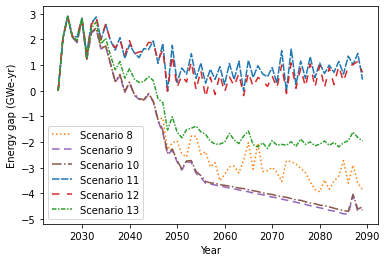

In [14]:
demand = 89.45655* np.exp(0.01*(time-2025))

for key in energy_1percent:
    scenario = key[:3]
    gap = demand-energy_1percent[key]['Energy'][58:]
    plt.plot(energy_1percent[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario], 
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend()
plt.savefig('figures/1percent_energy_gap.pdf')

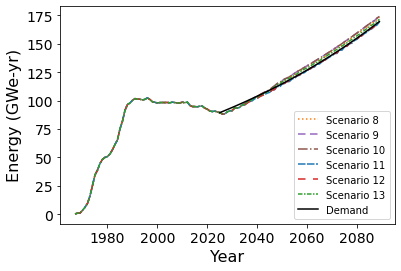

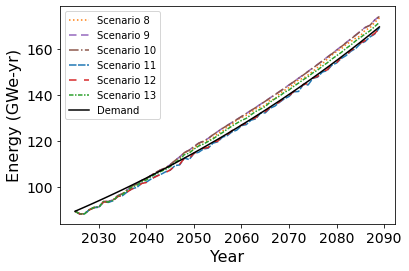

In [15]:
for key in energy_1percent:
    scenario = key[:3]
    plt.figure(0)
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
    
    plt.figure(1)
    plt.plot(energy_1percent[key]['Year'][58:], energy_1percent[key]['Energy'][58:], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy_after_2025.pdf', bbox_inches='tight')

In [230]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08':'', 's09':'', 's10':'',
                       's11':'', 's12':'', 's13':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

In [231]:
#Dividing fuel mass by prototype
uranium_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in uranium_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = tm.commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]

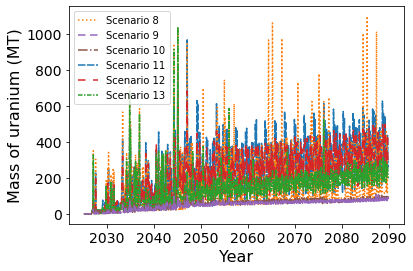

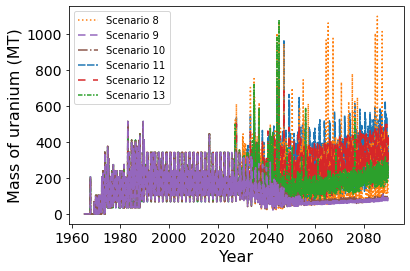

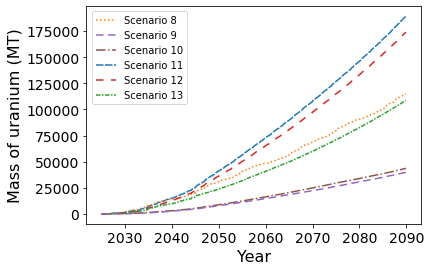

In [234]:
#markers = {'s08':1.5,'s09':1.5,'s10':4,'s11':1.5,'s12':1.5,'s13':1}
for key in plotting_order_1percent:

    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')

    ax2 = plt.figure(2)
    uranium_to_reactors_1percent[key+'_total'] = AR_uranium['Quantity'] + \
                                                uranium_to_reactors_1percent[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')
    
    ax3 = plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/1percent_uranium_cumulative.pdf', bbox_inches='tight')

In [255]:
#Reporting uranium masses
for scenario in plotting_order_1percent:
    HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR']['Quantity'] + \
                uranium_to_reactors_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_mass[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_mass[721:].max()/1000) 
    print('Cumulative mass in ', scenario, ':', AR_mass[721:].cumsum()[1499]/1000)    

Average HALEU mass in s11 after 2025: 28.547554741653567
Average mass in  s11 : 242.91155832409484
Maximum mass in  s11 : 967.3632460376559
Cumulative mass in  s11 : 189228.1039344698
Average HALEU mass in s08 after 2025: 147.4697715239992
Average mass in  s08 : 147.4697715239992
Maximum mass in  s08 : 1098.6765521044506
Cumulative mass in  s08 : 114878.95201719498
Average HALEU mass in s12 after 2025: 10.410085971757384
Average mass in  s12 : 223.29794996368872
Maximum mass in  s12 : 684.0616152984321
Cumulative mass in  s12 : 173949.10302171364
Average HALEU mass in s13 after 2025: 51.679991286370125
Average mass in  s13 : 139.6227908310199
Maximum mass in  s13 : 1039.9218838679737
Cumulative mass in  s13 : 108766.15405736459
Average HALEU mass in s10 after 2025: 55.989281241380965
Average mass in  s10 : 55.989281241380965
Maximum mass in  s10 : 114.69055473049062
Cumulative mass in  s10 : 43615.65008703579
Average HALEU mass in s09 after 2025: 51.13304172022301
Average mass in  s09 

In [236]:
#SWU Calculations
tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        tails_1percent[key] = tm.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_1percent[key] = tm.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'], 
                                           tails_1percent[key])
        SWU_1percent[key] = tm.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

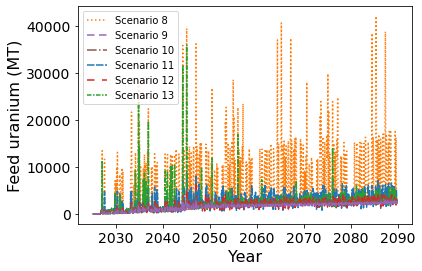

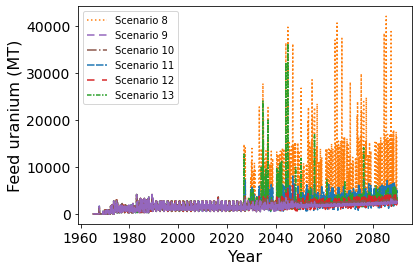

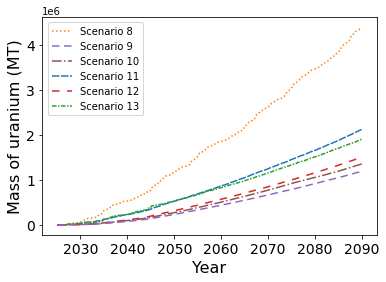

In [243]:
for key in ['s08','s11','s13','s12','s10','s09']:
    AR_feed = feed_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_1percent[key+'_total'] = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], feed_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key+'_MMR']['Year'][721:], AR_feed[721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 5, 4, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_feed_cumulative.pdf', bbox_inches='tight')

In [253]:
#Reporting feed masses
for scenario in plotting_order_1percent:
    HALEU_feed = feed_1percent[scenario+'_MMR']+feed_1percent[scenario+'_Xe-100']
    print('Average HALEU feed in',scenario,'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_1percent[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_feed[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_feed[721:].max()/1000)
    print('Cumulative mass in ', scenario, ':', AR_feed[721:].cumsum()[1499]/1000)

Average HALEU feed in s11 after 2025: 1092.1813996072938
Average mass in  s11 : 2724.032620616485
Maximum mass in  s11 : 9024.951019382443
Cumulative mass in  s11 : 2122021.41146024
Average HALEU feed in s08 after 2025: 5641.945270634413
Average mass in  s08 : 5641.945270634413
Maximum mass in  s08 : 42033.515838829764
Cumulative mass in  s08 : 4395075.365824206
Average HALEU feed in s12 after 2025: 311.69141950663015
Average mass in  s12 : 1932.3054917739744
Maximum mass in  s12 : 6068.691242298336
Cumulative mass in  s12 : 1505265.9780919272
Average HALEU feed in s13 after 2025: 1774.1896046233765
Average mass in  s13 : 2443.6563173996733
Maximum mass in  s13 : 35922.394539002664
Cumulative mass in  s13 : 1903608.2712543441
Average HALEU feed in s10 after 2025: 1739.9612398476675
Average mass in  s10 : 1739.9612398476675
Maximum mass in  s10 : 3600.1237200552137
Cumulative mass in  s10 : 1355429.805841332
Average HALEU feed in s09 after 2025: 1530.9893117796712
Average mass in  s09 :

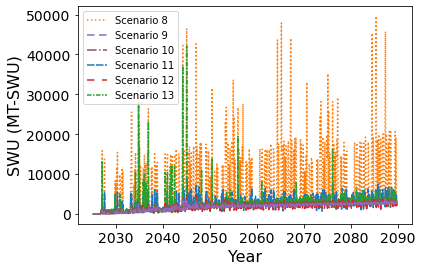

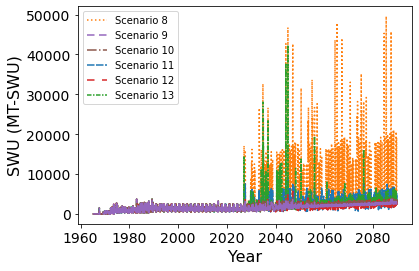

In [245]:
for key in ['s08','s11', 's13','s12','s10','s09']:
    AR_SWU = SWU_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_1percent[key+'_total'] = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], SWU_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 5, 4, 1, 3,2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_SWU.pdf', bbox_inches='tight')

In [246]:
#Reporting SWU requirements
for scenario in plotting_order_1percent:
    HALEU_SWU = SWU_1percent[scenario+'_MMR'] + SWU_1percent[scenario+'_Xe-100']
    print('Average SWU for HALEU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_1percent[scenario+'_VOYGR']
    print('Average capacity in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum capacity in ', scenario, ':', AR_SWU[721:].max()/1000)   

Average SWU for HALEU in s11 after 2025: 1288.0166901341208
Average capacity in  s11 : 2734.757027864801
Maximum capacity in  s11 : 8985.595878489878
Average SWU for HALEU in s08 after 2025: 6653.583073300183
Average capacity in  s08 : 6653.583073300183
Maximum capacity in  s08 : 49570.40100197295
Average SWU for HALEU in s12 after 2025: 358.84776970253256
Average capacity in  s12 : 1795.6256573295477
Maximum capacity in  s12 : 5686.012020638519
Average SWU for HALEU in s13 after 2025: 2071.8402517677814
Average capacity in  s13 : 2665.3652531110097
Maximum capacity in  s13 : 42080.78012576983
Average SWU for HALEU in s10 after 2025: 2011.395193605253
Average capacity in  s10 : 2011.395193605253
Maximum capacity in  s10 : 4166.203027636285
Average SWU for HALEU in s09 after 2025: 1762.6154125133496
Average capacity in  s09 : 1762.6154125133496
Maximum capacity in  s09 : 3693.351820609281


In [247]:
# Waste discharged from reactors
waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

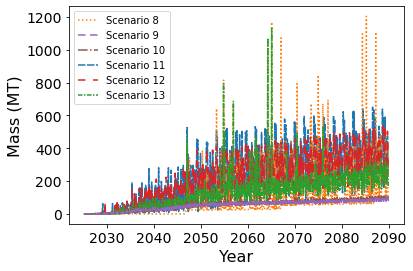

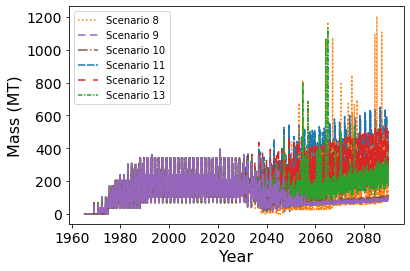

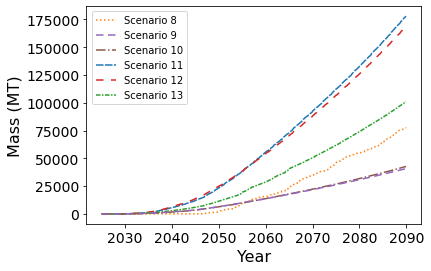

In [248]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    ax0 = plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
       
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_1percent[key+'_total'] = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_waste_cumulative.pdf', bbox_inches='tight')

In [252]:
#Reporting waste masses
for scenario in plotting_order_1percent:
    HALEU_waste = waste_1percent[scenario+'_MMR']['Quantity'] + waste_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in',scenario,'after 2025:', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_waste[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_waste[721:].max()/1000)
    print('Cumulative mass in ', scenario, ':', AR_waste[721:].cumsum()[1499]/1000)

Average HALEU waste in s11 after 2025: 20.276338421052625
Average mass in  s11 : 228.35790485237507
Maximum mass in  s11 : 650.3212160000019
Cumulative mass in  s11 : 177890.80788000018
Average HALEU waste in s08 after 2025: 99.93296663414635
Average mass in  s08 : 99.93296663414635
Maximum mass in  s08 : 1204.0964419999984
Cumulative mass in  s08 : 77847.78100799985
Average HALEU waste in s12 after 2025: 10.832815083440316
Average mass in  s12 : 216.64836236200276
Maximum mass in  s12 : 537.3921900000015
Cumulative mass in  s12 : 168769.07428000023
Average HALEU waste in s13 after 2025: 46.9861317869062
Average mass in  s13 : 129.70205618998708
Maximum mass in  s13 : 1130.8010719999907
Cumulative mass in  s13 : 101037.90177199984
Average HALEU waste in s10 after 2025: 54.86160524518603
Average mass in  s10 : 54.86160524518603
Maximum mass in  s10 : 112.34335400000035
Cumulative mass in  s10 : 42737.190485999934
Average HALEU waste in s09 after 2025: 52.35159062901149
Average mass in  